In [1]:
%pylab inline
import sys
sys.path.append('../')
from BayesianNamingGame import *
from scipy.stats import pearsonr
from scipy.stats import linregress
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
def join(*arrs, cols=None):
    """Joins arrays into a 2D matrix with K columns. If the array doesn't
    have K columns already, it is transposed if it does have K rows.
    
    Args:
        a list of arrays
        cols: the number of columsn (required)

    Returns:
        A ?-by-cols matrix 
    """
    if not cols:
        raise ValueError('Number of colums not specified')
        
    to_join = []
    for arr in arrs:
        if len(arr.shape) == 1:
            if arr.shape[0] == cols:
                to_join.append([arr])
            else:
                raise ValueError('Array does not have appropriate size')
        else:
            if arr.shape[1] == cols:
                to_join.append(arr)
            elif arr.shape[0] == cols:
                to_join.append(arr.T)
            else:
                raise ValueError('Array does not have appropriate size')
    return np.concatenate(to_join)

def norm_JSD(ps, K=None):
    K = K if K else ps.shape[1]
    return JSD(ps) / np.log2(K)

def normalize(arr, axis=1):
    """Normalize an array along a certain axis"""
    _arr = arr if type(arr) == np.ndarray else np.array(arr)
    if len(_arr.shape) == 1:
        return normalize([arr])[0]
    else:
        return _arr / _arr.sum(axis=axis)[:, np.newaxis]

def sliced_psi(xs, slice_size):
    """Computes the empirical distribution of utterances (psi) uttered in
    different time-slices [0, ..., t), [t, ..., 2t), ..., [T-t, ..., T).
    That is, it computes psi^(0:t), psi^(t:2t), psi^(2t, 3t) and so on.
    If these distributions are all similar, the population most likely
    converges to a stable language. If the divergence is larger, the language
    is most likely unstable
    
    Args:
        xs: a TxK matrix with utterance counts in every round
        binsize: the size of the slices
        
    Returns:
        a (T//slice_size)xK matrix with the empirical distribution psi over
        words in every slice. 
    """
    T, K = xs.shape
    slice_size = min(slice_size, T)
    slices = T // slice_size
    
    # Compute the empirical distribution on every slice
    distributions = np.zeros((slices, K))
    for i, start in enumerate(arange(T-slices*slice_size, T, slice_size)):
        end = start + slice_size
        vs = xs[start:end].sum(axis=0)
        distributions[i,:] = normalize(vs)
    
    return JSD(distributions), distributions

In [3]:
def analyze_simulation_runs(fn, runs):
    """
    Analyzes simulation runs by collecting various statistics:
        - JSD(\phi_1, ... \phi_N): divergence between agents 
            distributions at the end of the simulation
        - JSD(alpha, \bar\phi): divergence between mean dist
            and prior at the end of the simulation
        - H(\bar\phi): entropy of mean distribution at the end
        - std(JSD(\phi_1^(t), ... \phi_N^(t))): standard deviation of
            div. of agent distributions over time
        - std(JSD(alpha, \bar\phi^(t))): std of mean agent distribution 
            and prior over time
        - pearson_r: Pearson correlation coefficient between log(t) and
            log(JSD(phi_i)). If the distributions converge you expect
            a linear decline.
        - pearson_r_p_value: p-value of the above correlation
        - JSD(\psi, \bar\phi): divergence between time-average (of all
            words uttered) and mean agent distribution at the end
        - H(psi): entropy of time-average at the end
        - JSD(psi, alpha): divergence between time average and prior 
            at the end of the simulation
        - JSD(psi^(0:t), psi(t:2t), ... psi^(T-t:T)): divergence between
            time-averages of slices of the entire simulation.
    
    Besides, we collect divergences averaged over all runs of:
        - JSD(\phi_1, ... \phi_N)
        - JSD(\phi_1, ... \phi_N)
        - H(\bar\phi)
        
    All this is returned in two pandas dataframes; one with the statistics
    listed first, for every run, and one with the divergences over time
    averaged across runs.
    """

    # Load shared params
    params = load_simulation(fn.format(1), params_only=True)
    alpha_ps = normalize(params['alpha'])
    D = len(params['datapoints'])

    # Collect all stats in a single matrix
    divergences = np.zeros((runs, D, 4))

    # Prepare a array with all statistics
    stats_columns = [
        'jsd_phis',
        'jsd_alpha_mphi',
        'entropy_mphi',
        'std_jsd_phis',
        'std_alpha_mphi',
        'pearson_r',
        'pearson_r_p_value',
        'jsd_mphi_psi',
        'entropy_psi',
        'jsd_psi_alpha',
        'jsd_psi_slices'
    ]
    all_stats = np.zeros((runs, len(stats_columns)))

    # Burn in 
    burn = 10000
    burn_idx = np.where(params['datapoints'] > burn)[0].min()

    for run in range(1, runs+1):
        base = fn.format(run)
        name = os.path.basename(base)
        print('Starting with', name)

        results = load_simulation(base)

        # Store all divergences
        divs = results['stats'].as_matrix()
        divergences[run-1,:,:] = divs

        # Pearson correlation between log(t) and log(jsd(*phi))
        jsd_phis = results['stats']['JSD(*phis)']
        r, prob_r = pearsonr(log10(jsd_phis.index[burn_idx:]), 
                     log10(jsd_phis.values[burn_idx:]))

        # Compute JSD of psi^(T) and alpha
        psi_T = normalize(results['utterances'].sum(axis=0))
        jsd_psi_T_alpha = JSD(join(psi_T, alpha_ps, cols=params['K']))

        # JSD between psi across slices
        jsd_psi_slices, _ = sliced_psi(results['utterances'], 2000)

        # JSD between phi^(T) and psi^(T)
        mphi_T = results['phis'].mean(axis=0)
        jsd_psi_T_mphi_T = JSD(join(psi_T, mphi_T, cols=params['K']))

        # Save all those stats
        all_stats[run-1,:] = (
            results['stats']['JSD(*phis)'].iloc[-1],
            results['stats']['JSD(alpha, mean(*phis))'].iloc[-1],
            results['stats']['H(mean(*phi))'].iloc[-1],
            results['stats']['JSD(alpha, *phis)'].iloc[burn_idx:].std(),
            results['stats']['JSD(alpha, mean(*phis))'].iloc[burn_idx:].std(),
            r, 
            prob_r, 
            jsd_psi_T_mphi_T,
            entropy(psi_T),
            jsd_psi_T_alpha,
            jsd_psi_slices)

    # Store means and stds in a dataframe
    means = divergences.mean(axis=0)
    std = divergences.std(axis=0)
    _cols = results['stats'].columns
    columns = pd.MultiIndex.from_arrays([
        list(flatten([[c]*2 for c in _cols])),
        ['mean', 'std'] * len(_cols)])
    divergences_df = pd.DataFrame(np.concatenate([means, std], axis=1),
          index=params['datapoints'], columns=columns)

    # Store all statistics in a dataframe
    stats_df = pd.DataFrame(all_stats, columns=stats_columns)
    stats_df.index.name='run'
    
    return divergences_df, stats_df

In [22]:
for gamma in [50,100, 1000, 100000000]:
    for zeta in [1.5]:
        print('\n\nSTARTING zeta={}, gamma={}'.format(zeta,gamma))
        # Run!
        folder = 'results/gamma-{}'.format(gamma)
        name = 'BNG05-zeta-{}'.format(zeta)
        fn = os.path.join(folder, name+'-run-{:0>4}')
        div_df, stats_df = analyze_simulation_runs(fn, 30)

        # Dump
        stats_df.to_csv(os.path.join(folder, name+'-stats.csv'))
        div_df.to_csv(os.path.join(folder, name+'-divs.csv'))



STARTING zeta=1.5, gamma=50
Starting with BNG05-zeta-1.5-run-0001
Starting with BNG05-zeta-1.5-run-0002
Starting with BNG05-zeta-1.5-run-0003
Starting with BNG05-zeta-1.5-run-0004
Starting with BNG05-zeta-1.5-run-0005
Starting with BNG05-zeta-1.5-run-0006
Starting with BNG05-zeta-1.5-run-0007
Starting with BNG05-zeta-1.5-run-0008
Starting with BNG05-zeta-1.5-run-0009
Starting with BNG05-zeta-1.5-run-0010
Starting with BNG05-zeta-1.5-run-0011
Starting with BNG05-zeta-1.5-run-0012
Starting with BNG05-zeta-1.5-run-0013
Starting with BNG05-zeta-1.5-run-0014
Starting with BNG05-zeta-1.5-run-0015
Starting with BNG05-zeta-1.5-run-0016
Starting with BNG05-zeta-1.5-run-0017
Starting with BNG05-zeta-1.5-run-0018
Starting with BNG05-zeta-1.5-run-0019
Starting with BNG05-zeta-1.5-run-0020
Starting with BNG05-zeta-1.5-run-0021
Starting with BNG05-zeta-1.5-run-0022
Starting with BNG05-zeta-1.5-run-0023
Starting with BNG05-zeta-1.5-run-0024
Starting with BNG05-zeta-1.5-run-0025
Starting with BNG05-

# Older

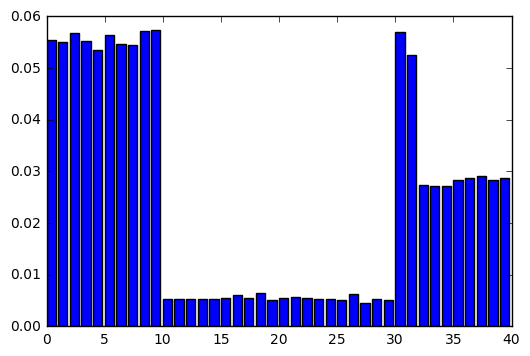

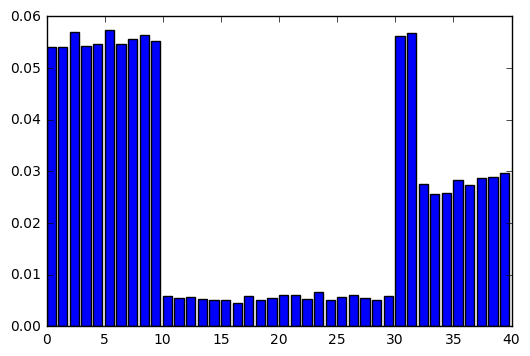

In [118]:
fn = 'results/gamma-1/BNG05-zeta-1-run-{:0>4}'
runs = 2

# Read out the first simulation 
basename = os.path.basename(fn.format(1))
params_fn = os.path.join(fn.format(1), basename + '-params.json')
params = json.load(open(params_fn, 'r'))
final_stats = np.zeros((runs, 2))

alpha = array(params['alpha'])
alpha_ps = alpha/alpha.sum()
alpha_entropy = entropy(alpha)

for run in range(1, runs+1):
    res = load_simulation(fn.format(run))
    
    # Compute time-averaged distribution
    vs = array(res['utterances'].sum(axis=0))[0]
    ps = vs / sum(vs)
    
    # Distance between the time-averaged distribution and alpha
    jsd_to_alpha = JSD(np.concatenate([[ps], [alpha_ps]]))
    
    # Entropy of the time-averaged distribution
    ent = entropy(ps) / log2(params['K'])
    
    # Save these statistics
    final_stats[run-1,:] = (jsd_to_alpha, ent)

df = pd.DataFrame(final_stats, columns=['JSD to alpha', 'entropy'])

### Compute mean statistics

In [183]:
def load_mean_divergences(fn, runs):

    # Read out the first simulation 
    res1 = load_simulation(fn.format(1))
    stats1 = res1['stats'].as_matrix()

    # Collect all stats in a single matrix
    all_stats = np.zeros(tuple([runs]) + stats1.shape)

    for run in range(2, runs):
        res = load_simulation(fn.format(run))
        all_stats[run,:,:] = res['stats'].as_matrix()

    # Store means and stds in a dataframe
    means = all_stats.mean(axis=0)
    std = all_stats.std(axis=0)
    _cols = res1['stats'].columns
    columns = pd.MultiIndex.from_arrays([
        list(flatten([[c]*2 for c in _cols])),
        ['mean', 'std'] * len(_cols)])
    df = pd.DataFrame(np.concatenate([means, std], axis=1),
          index=res1['datapoints'], columns=columns)
    
    return df

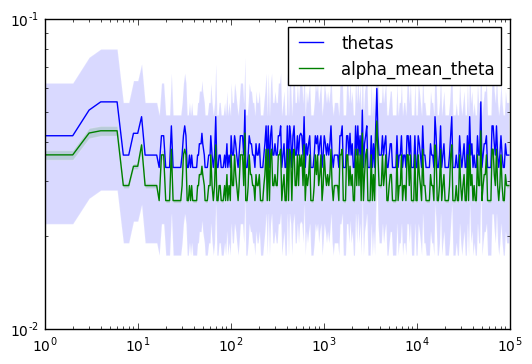

In [129]:
for name in ['thetas', 'alpha_mean_theta']:
    mean, std = df[name]['mean'], df[name]['std']
    l, = pyplot.loglog(df.index, mean, label=name)
    fill_between(df.index, mean+.5*std, mean-.5*std, 
                 where = mean-.5*std > 0,
                 alpha=.15, facecolor=l.get_color(), edgecolor='w')
legend()